In [1]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_cohorts(df, step=5, func=None, cumulative=False):
    results = []
    max_nb_ratings = df['nb_train_ratings'].max()
    start, end = 0, step
    while end < max_nb_ratings:
        mask = (df['nb_train_ratings'] >= start) & (df['nb_train_ratings'] < end)
        df_cohort = df.loc[mask]
        cohort_result = func(df_cohort) if func else df_cohort
        results.append(cohort_result)
        if not cumulative:
            start += step
        end += step
    return results

def get_user_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('user_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def get_movie_cohorts(df_train, step=5, cumulative=False):
    df_train = df_train.groupby('movie_id')['rating'].count().reset_index()
    df_train = df_train.rename(columns={'rating': 'nb_train_ratings'})
    return get_cohorts(df_train, step=step, cumulative=cumulative)

def plot_user_cohort_distribution(df_train, step=5):
    print "Cohort 0: users who have 0-5 training ratings"
    print "Cohort 1: users who have 5-10 training ratings"
    
    user_cohorts = get_user_cohorts(df_train, step=step)
    nb_users_per_cohort = map(lambda df: len(df), user_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of users')
    ax.set_xlabel('cohort (users)')
    ax.plot(xrange(len(nb_users_per_cohort)),nb_users_per_cohort, 'b')
    
    cumulative_users = np.cumsum(nb_users_per_cohort, dtype=np.float)
    cumulative_users /= cumulative_users[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of users')
    ax.set_xlabel('max # training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_users))]
    ax.plot(x_axis,cumulative_users, 'b')
    
def plot_movie_cohort_distribution(df_train, step=5):
    print "Cohort 0: movies who have 0-5 training ratings"
    print "Cohort 1: movies who have 5-10 training ratings"
    
    movie_cohorts = get_movie_cohorts(df_train, step=step)
    nb_movies_per_cohort = map(lambda df: len(df), movie_cohorts)
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('number of movies')
    ax.set_xlabel('cohort (movie)')
    ax.plot(xrange(len(nb_movies_per_cohort)),nb_movies_per_cohort, 'b')
    
    cumulative_movies = np.cumsum(nb_movies_per_cohort, dtype=np.float)
    cumulative_movies /= cumulative_movies[-1]
    fig = plt.figure(figsize=(15,10))
    ax = plt.gca()
    ax.set_ylabel('percent of movies')
    ax.set_xlabel('movies that have x or less training ratings')
    x_axis = [(i+1) * step for i in xrange(len(cumulative_movies))]
    ax.plot(x_axis,cumulative_movies, 'b')
    
def plot_tail(df_ratings, fig=None, color='r', label=''):
    df_lt = df_ratings.groupby('movie_id').count().reset_index()[['movie_id', 'rating']].sort_values('rating', ascending=False)
    
    if not fig:
        fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    ax.set_ylabel('# Ratings', size=15)
    ax.set_xlabel('Rank', size=15)
    x_axis = range(len(df_lt))
    ax.plot(x_axis, df_lt['rating'].values, color, label=label)
    #ax.set_xticklabels([])
    ax.legend(loc='upper right')
    return fig

def plot_metric(model_metrics, metric_name, step=5, cumulative=False, mlabel='', xlabel='', ylabel='', nb_cohorts=None, fig=None, color='r', loc='upper right'):
    func = lambda df: df[metric_name].mean()
    
    model_metric_per_cohort = get_cohorts(model_metrics, step=step, func=func, cumulative=cumulative)
    
    if nb_cohorts:
        model_metric_per_cohort = model_metric_per_cohort[:nb_cohorts]
    
    if not fig:
        fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    ax.tick_params(labelsize=12)
    
    if len(ylabel) > 0:
        ax.set_ylabel(ylabel, size=15)

    if len(xlabel) > 0:
            ax.set_xlabel(xlabel, size=15)
    
    if cumulative:
        x_axis = [(i+1) * step for i in xrange(len(model_metric_per_cohort))]
    else:
        x_axis = [i for i in xrange(len(model_metric_per_cohort))]
    #assert len(model1_metric_per_cohort) == len(model2_metric_per_cohort)

    ax.plot(x_axis, model_metric_per_cohort, color, label=mlabel)
    
    if loc:
        ax.legend(loc=loc, fontsize=13)
    
    print "avg {} for {} model:\t".format(metric_name, mlabel), model_metrics[metric_name].mean()
    
    return fig

## ML-100k

In [3]:
metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_user-metrics.csv')
cv_paths = [
'../metrics/mpcf-si/2016-06-27_15.54.03_si_ml-100k_e20_tt-0.7_train-2_user-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.38.42_si_ml-100k_e20_tt-0.7_train-3_user-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.40.07_si_ml-100k_e20_tt-0.7_train-4_user-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.40.38_si_ml-100k_e20_tt-0.7_train-5_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_si_metrics = metrics

metrics = pd.read_csv('../metrics/mpcf-si/2016-06-27_08.23.04_si_ml-100k_e20_tt-0.7_task-1_movie-metrics.csv')
cv_paths = [
'../metrics/mpcf-si/2016-06-27_15.54.03_si_ml-100k_e20_tt-0.7_train-2_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.38.42_si_ml-100k_e20_tt-0.7_train-3_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.40.07_si_ml-100k_e20_tt-0.7_train-4_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-27_15.40.38_si_ml-100k_e20_tt-0.7_train-5_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_si_movie_metrics = metrics

In [4]:
metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_user-metrics.csv')
cv_paths = [
'../metrics/mpcf/2016-06-22_14.53.14_no-si_ml-100k_e20_tt-0.7_train-4_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_14.53.43_no-si_ml-100k_e20_tt-0.7_train-5_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_14.53.53_no-si_ml-100k_e20_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_14.55.55_no-si_ml-100k_e20_tt-0.7_train-3_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_metrics = metrics

metrics = pd.read_csv('../metrics/mpcf/2016-06-20_18.30.50_no-si_ml-100k_e20_tt-0.7_base_movie-metrics.csv')
cv_paths = [
'../metrics/mpcf/2016-06-22_14.53.14_no-si_ml-100k_e20_tt-0.7_train-4_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_14.53.43_no-si_ml-100k_e20_tt-0.7_train-5_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_14.53.53_no-si_ml-100k_e20_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_14.55.55_no-si_ml-100k_e20_tt-0.7_train-3_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_movie_metrics = metrics

In [5]:
metrics = pd.read_csv('../metrics/mfnn/2016-07-06_00.04.50_mfnn_ml-100k_e20_tt-0.7_task-13_user-metrics.csv')
cv_paths = [
'../metrics/mfnn/2016-07-06_15.38.20_mfnn_ml-100k_e20_tt-0.7_train-2_user-metrics.csv',
'../metrics/mfnn/2016-07-06_15.40.55_mfnn_ml-100k_e20_tt-0.7_train-3_user-metrics.csv',
'../metrics/mfnn/2016-07-06_15.40.31_mfnn_ml-100k_e20_tt-0.7_train-4_user-metrics.csv',
'../metrics/mfnn/2016-07-06_15.42.05_mfnn_ml-100k_e20_tt-0.7_train-5_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mfnn_metrics = metrics

metrics = pd.read_csv('../metrics/mfnn/2016-07-06_00.04.50_mfnn_ml-100k_e20_tt-0.7_task-13_movie-metrics.csv')
cv_paths = [
'../metrics/mfnn/2016-07-06_15.38.20_mfnn_ml-100k_e20_tt-0.7_train-2_movie-metrics.csv',
'../metrics/mfnn/2016-07-06_15.40.55_mfnn_ml-100k_e20_tt-0.7_train-3_movie-metrics.csv',
'../metrics/mfnn/2016-07-06_15.40.31_mfnn_ml-100k_e20_tt-0.7_train-4_movie-metrics.csv',
'../metrics/mfnn/2016-07-06_15.42.05_mfnn_ml-100k_e20_tt-0.7_train-5_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mfnn_movie_metrics = metrics

In [6]:
metrics = pd.read_csv('../metrics/bprmf/2016-05-27_16.15.55_bprmf_ml-100k_e20_tt-0.7_task-20_user-metrics.csv')
cv_paths = [
'../metrics/bprmf/2016-06-22_14.36.02_bprmf_ml-100k_e20_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_14.36.46_bprmf_ml-100k_e20_tt-0.7_train-3_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_14.37.19_bprmf_ml-100k_e20_tt-0.7_train-4_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_14.38.46_bprmf_ml-100k_e20_tt-0.7_train-5_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

bprmf_metrics = metrics

metrics = pd.read_csv('../metrics/bprmf/2016-05-27_16.15.55_bprmf_ml-100k_e20_tt-0.7_task-20_movie-metrics.csv')
cv_paths = [
'../metrics/bprmf/2016-06-22_14.36.02_bprmf_ml-100k_e20_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_14.36.46_bprmf_ml-100k_e20_tt-0.7_train-3_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_14.37.19_bprmf_ml-100k_e20_tt-0.7_train-4_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_14.38.46_bprmf_ml-100k_e20_tt-0.7_train-5_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

bprmf_movie_metrics = metrics

In [7]:
metrics = pd.read_csv('../metrics/slim/2016-05-31_15.17.43_slim_ml-100k_e5_tt-0.7_task-16_user-metrics.csv')
cv_paths = [
'../metrics/slim/2016-06-22_14.07.36_slim_ml-100k_e5_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.08.21_slim_ml-100k_e5_tt-0.7_train-3_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.09.49_slim_ml-100k_e5_tt-0.7_train-4_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.10.56_slim_ml-100k_e5_tt-0.7_train-5_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

slim_metrics = metrics

metrics = pd.read_csv('../metrics/slim/2016-05-31_15.17.43_slim_ml-100k_e5_tt-0.7_task-16_movie-metrics.csv')
cv_paths = [
'../metrics/slim/2016-06-22_14.07.36_slim_ml-100k_e5_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.08.21_slim_ml-100k_e5_tt-0.7_train-3_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.09.49_slim_ml-100k_e5_tt-0.7_train-4_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.10.56_slim_ml-100k_e5_tt-0.7_train-5_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

slim_movie_metrics = metrics

avg auc for MPCFs-SI model:	0.937636280679
avg auc for MPCFs model:	0.936534181078
avg auc for MFNN model:	0.934477114128
avg auc for BPRMF model:	0.922011474037
avg auc for SLIM model:	0.914456027015


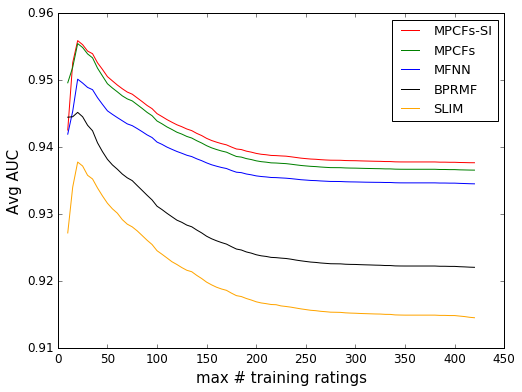

In [8]:
step=5
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs-SI', xlabel='max # training ratings', ylabel='Avg AUC')
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g')
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b')
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black')
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange')
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_auc.pdf')

avg auc for MPCFs-SI model:	0.870157900253
avg auc for MPCFs model:	0.869667178268
avg auc for MFNN model:	0.859702284831
avg auc for BPRMF model:	0.651724435906
avg auc for SLIM model:	0.816200759371


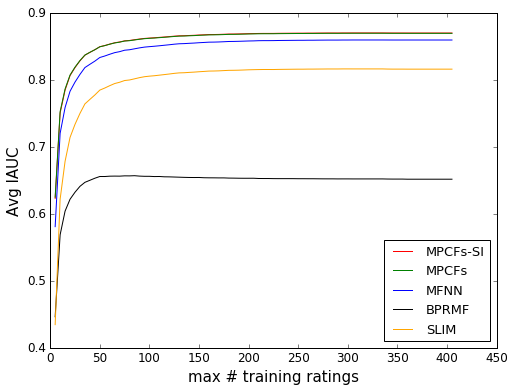

In [9]:
step=5
loc='lower right'
fig = plot_metric(mpcf_si_movie_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs-SI', xlabel='max # training ratings', ylabel='Avg IAUC',loc=loc)
fig = plot_metric(mpcf_movie_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g',loc=loc)
fig = plot_metric(mfnn_movie_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b',loc=loc)
fig = plot_metric(bprmf_movie_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black',loc=loc)
fig = plot_metric(slim_movie_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange',loc=loc)
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_iauc.pdf')

avg spearman_rank_corr for MPCFs-SI model:	0.20050986492
avg spearman_rank_corr for MPCFs model:	0.197424919111
avg spearman_rank_corr for MFNN model:	0.192480053706
avg spearman_rank_corr for BPRMF model:	0.15670286614
avg spearman_rank_corr for SLIM model:	0.187982544849


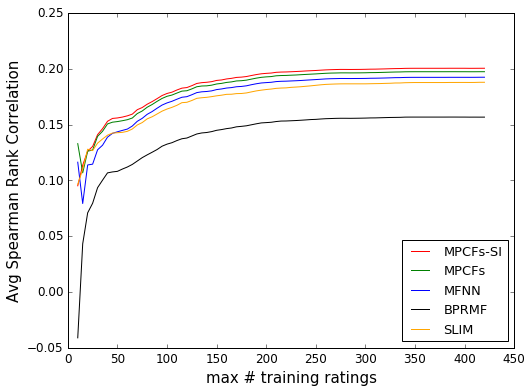

In [10]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'spearman_rank_corr', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='max # training ratings',
                  ylabel='Avg Spearman Rank Correlation', loc=loc)
fig = plot_metric(mpcf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc)
fig = plot_metric(mfnn_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc)
fig = plot_metric(bprmf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc)
fig = plot_metric(slim_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc)
src_fig = fig
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_src.pdf')

avg precision_at_20 for MPCFs-SI model:	0.281558854719
avg precision_at_20 for MPCFs model:	0.277921527041
avg precision_at_20 for MFNN model:	0.284400848356
avg precision_at_20 for BPRMF model:	0.179650053022
avg precision_at_20 for SLIM model:	0.234888653234


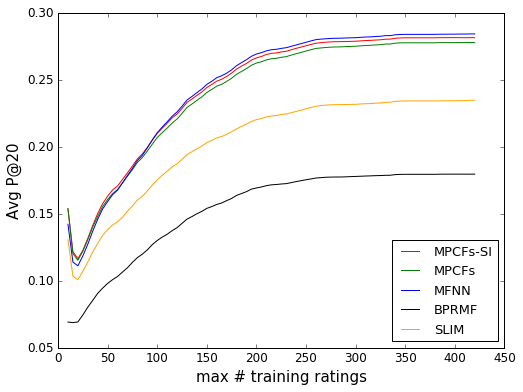

In [11]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'precision_at_20', step=step,cumulative=cum,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Avg P@20', loc=loc)
fig = plot_metric(mpcf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc)
p20_fig = fig
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_p20.pdf')

avg recall_at_20 for MPCFs-SI model:	0.442723143578
avg recall_at_20 for MPCFs model:	0.435520455173
avg recall_at_20 for MFNN model:	0.439615126532
avg recall_at_20 for BPRMF model:	0.273830977288
avg recall_at_20 for SLIM model:	0.377538152214


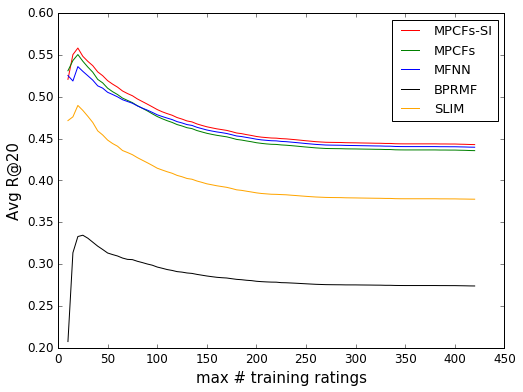

In [12]:
step=5
loc = 'upper right'
fig = plot_metric(mpcf_si_metrics, 'recall_at_20', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Avg R@20', loc=loc)
fig = plot_metric(mpcf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc)
r20_fig = fig
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_r20.pdf')

avg reciprocal_rank for MPCFs-SI model:	0.686567736391
avg reciprocal_rank for MPCFs model:	0.677031459827
avg reciprocal_rank for MFNN model:	0.674110268575
avg reciprocal_rank for BPRMF model:	0.370306965769
avg reciprocal_rank for SLIM model:	0.59926227496


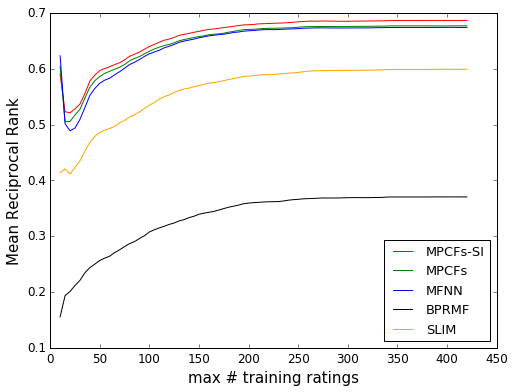

In [13]:
step=5
loc='lower right'
cum=True
fig = plot_metric(mpcf_si_metrics, 'reciprocal_rank', step=step,cumulative=cum, 
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Mean Reciprocal Rank', loc=loc)
fig = plot_metric(mpcf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc)
fig = plot_metric(mfnn_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc)
fig = plot_metric(bprmf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc)
fig = plot_metric(slim_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc)
mrr_fig = fig
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_comparison_mrr.pdf')

## ML-1M

In [14]:
metrics = pd.read_csv('../metrics/mpcf-si/2016-06-29_13.23.36_si_ml-1m_e20_tt-0.7_task-0_user-metrics.csv')
cv_paths = [
'../metrics/mpcf-si/2016-06-30_07.38.02_si_ml-1m_e20_tt-0.7_train-2_user-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.32.45_si_ml-1m_e20_tt-0.7_train-3_user-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.36.22_si_ml-1m_e20_tt-0.7_train-4_user-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.35.21_si_ml-1m_e20_tt-0.7_train-5_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_si_metrics = metrics

metrics = pd.read_csv('../metrics/mpcf-si/2016-06-29_13.23.36_si_ml-1m_e20_tt-0.7_task-0_movie-metrics.csv')
cv_paths = [
'../metrics/mpcf-si/2016-06-30_07.38.02_si_ml-1m_e20_tt-0.7_train-2_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.32.45_si_ml-1m_e20_tt-0.7_train-3_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.36.22_si_ml-1m_e20_tt-0.7_train-4_movie-metrics.csv',
'../metrics/mpcf-si/2016-06-30_07.35.21_si_ml-1m_e20_tt-0.7_train-5_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_si_movie_metrics = metrics

In [15]:
metrics = pd.read_csv('../metrics/mpcf/2016-05-27_20.57.43_no-si_ml-1m_e20_tt-0.7_task-22_user-metrics.csv')
cv_paths = [
'../metrics/mpcf/2016-06-22_19.55.46_no-si_ml-1m_e20_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_19.56.10_no-si_ml-1m_e20_tt-0.7_train-5_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_19.56.50_no-si_ml-1m_e20_tt-0.7_train-3_task-0_user-metrics.csv',
'../metrics/mpcf/2016-06-22_19.59.20_no-si_ml-1m_e20_tt-0.7_train-4_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_metrics = metrics

metrics = pd.read_csv('../metrics/mpcf/2016-05-27_20.57.43_no-si_ml-1m_e20_tt-0.7_task-22_movie-metrics.csv')
cv_paths = [
'../metrics/mpcf/2016-06-22_19.55.46_no-si_ml-1m_e20_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_19.56.10_no-si_ml-1m_e20_tt-0.7_train-5_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_19.56.50_no-si_ml-1m_e20_tt-0.7_train-3_task-0_movie-metrics.csv',
'../metrics/mpcf/2016-06-22_19.59.20_no-si_ml-1m_e20_tt-0.7_train-4_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mpcf_movie_metrics = metrics

In [16]:
metrics = pd.read_csv('../metrics/mfnn/2016-07-06_10.04.44_mfnn_ml-1m_e10_tt-0.7_task-0_user-metrics.csv')
cv_paths = [
'../metrics/mfnn/2016-07-07_19.50.15_mfnn_ml-1m_e10_tt-0.7_train-2_user-metrics.csv',
'../metrics/mfnn/2016-07-07_19.49.55_mfnn_ml-1m_e10_tt-0.7_train-3_user-metrics.csv',
'../metrics/mfnn/2016-07-07_19.51.28_mfnn_ml-1m_e10_tt-0.7_train-4_user-metrics.csv',
'../metrics/mfnn/2016-07-07_19.51.20_mfnn_ml-1m_e10_tt-0.7_train-5_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mfnn_metrics = metrics

metrics = pd.read_csv('../metrics/mfnn/2016-07-06_10.04.44_mfnn_ml-1m_e10_tt-0.7_task-0_movie-metrics.csv')
cv_paths = [
'../metrics/mfnn/2016-07-07_19.50.15_mfnn_ml-1m_e10_tt-0.7_train-2_movie-metrics.csv',
'../metrics/mfnn/2016-07-07_19.49.55_mfnn_ml-1m_e10_tt-0.7_train-3_movie-metrics.csv',
'../metrics/mfnn/2016-07-07_19.51.28_mfnn_ml-1m_e10_tt-0.7_train-4_movie-metrics.csv',
'../metrics/mfnn/2016-07-07_19.51.20_mfnn_ml-1m_e10_tt-0.7_train-5_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

mfnn_movie_metrics = metrics

In [17]:
metrics = pd.read_csv('../metrics/bprmf/2016-05-24_18.04.12_bprmf_ml-1m_e20_tt-0.7_task-19_user-metrics.csv')
cv_paths = [
'../metrics/bprmf/2016-06-22_18.14.33_bprmf_ml-1m_e20_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_18.15.52_bprmf_ml-1m_e20_tt-0.7_train-3_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_18.16.36_bprmf_ml-1m_e20_tt-0.7_train-4_task-0_user-metrics.csv',
'../metrics/bprmf/2016-06-22_18.16.59_bprmf_ml-1m_e20_tt-0.7_train-5_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

bprmf_metrics = metrics

metrics = pd.read_csv('../metrics/bprmf/2016-05-24_18.04.12_bprmf_ml-1m_e20_tt-0.7_task-19_movie-metrics.csv')
cv_paths = [
'../metrics/bprmf/2016-06-22_18.14.33_bprmf_ml-1m_e20_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_18.15.52_bprmf_ml-1m_e20_tt-0.7_train-3_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_18.16.36_bprmf_ml-1m_e20_tt-0.7_train-4_task-0_movie-metrics.csv',
'../metrics/bprmf/2016-06-22_18.16.59_bprmf_ml-1m_e20_tt-0.7_train-5_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

bprmf_movie_metrics = metrics

In [18]:
metrics = pd.read_csv('../metrics/slim/2016-05-31_15.25.26_slim_ml-1m_e5_tt-0.7_task-10_user-metrics.csv')
cv_paths = [
'../metrics/slim/2016-06-22_14.44.11_slim_ml-1m_e5_tt-0.7_train-2_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.44.37_slim_ml-1m_e5_tt-0.7_train-3_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.45.33_slim_ml-1m_e5_tt-0.7_train-4_task-0_user-metrics.csv',
'../metrics/slim/2016-06-22_14.46.16_slim_ml-1m_e5_tt-0.7_train-5_task-0_user-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

slim_metrics = metrics

metrics = pd.read_csv('../metrics/slim/2016-05-31_15.25.26_slim_ml-1m_e5_tt-0.7_task-10_movie-metrics.csv')
cv_paths = [
'../metrics/slim/2016-06-22_14.44.11_slim_ml-1m_e5_tt-0.7_train-2_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.44.37_slim_ml-1m_e5_tt-0.7_train-3_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.45.33_slim_ml-1m_e5_tt-0.7_train-4_task-0_movie-metrics.csv',
'../metrics/slim/2016-06-22_14.46.16_slim_ml-1m_e5_tt-0.7_train-5_task-0_movie-metrics.csv',
]
for cv in cv_paths:
    metrics = metrics.append(pd.read_csv(cv))

slim_movie_metrics = metrics

avg auc for MPCFs-SI model:	0.928801675581
avg auc for MPCFs model:	0.928129741024
avg auc for MFNN model:	0.928891054078
avg auc for BPRMF model:	0.918249355796
avg auc for SLIM model:	0.912339379467


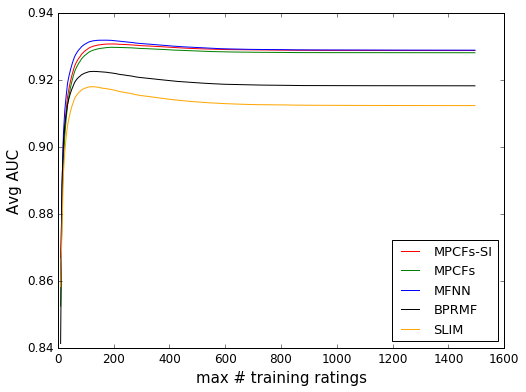

In [19]:
step=5
loc='lower right'
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings', 
                  ylabel='Avg AUC', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_auc.pdf')

avg auc for MPCFs-SI model:	0.928801675581
avg auc for MPCFs model:	0.928129741024
avg auc for MFNN model:	0.928891054078
avg auc for BPRMF model:	0.918249355796
avg auc for SLIM model:	0.912339379467


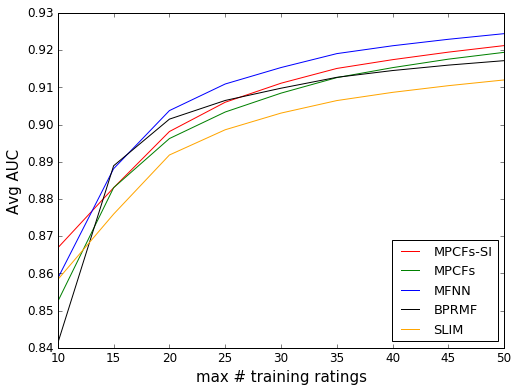

In [20]:
step=5
loc='lower right'
nb_cohorts=10
cum = True
fig = plot_metric(mpcf_si_metrics, 'auc', step=step,cumulative=cum,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings', 
                  ylabel='Avg AUC', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'auc', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'auc', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'auc', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'auc', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_auc_zoom.pdf')

avg auc for MPCFs-SI model:	0.911993683975
avg auc for MPCFs model:	0.911292169941
avg auc for MFNN model:	0.907827427815
avg auc for BPRMF model:	0.668419822711
avg auc for SLIM model:	0.870948879391


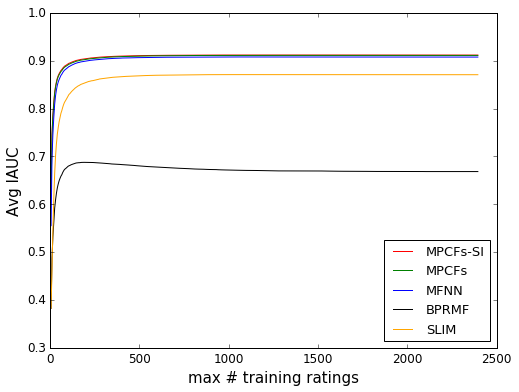

In [21]:
step=5
loc='lower right'
nb_cohorts=None
fig = plot_metric(mpcf_si_movie_metrics, 'auc', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings', 
                  ylabel='Avg IAUC', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_movie_metrics, 'auc', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_movie_metrics, 'auc', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_movie_metrics, 'auc', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_movie_metrics, 'auc', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_iauc.pdf')

avg spearman_rank_corr for MPCFs-SI model:	0.225963046363
avg spearman_rank_corr for MPCFs model:	0.222261934676
avg spearman_rank_corr for MFNN model:	0.235072855754
avg spearman_rank_corr for BPRMF model:	0.201303988065
avg spearman_rank_corr for SLIM model:	0.232186041798


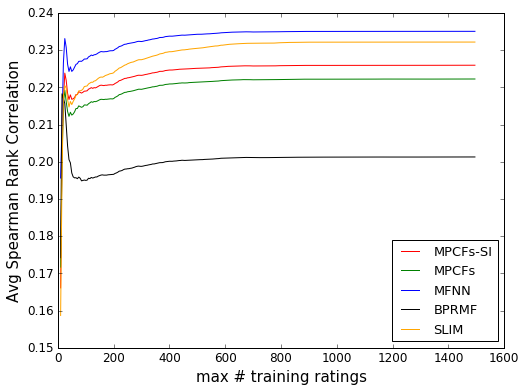

In [22]:
step=5
loc='lower right'
cum=True
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'spearman_rank_corr', step=step,cumulative=cum,
                  mlabel='MPCFs-SI',
                  xlabel='max # training ratings',
                  ylabel='Avg Spearman Rank Correlation', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black',loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'spearman_rank_corr', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange',loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_src.pdf')

avg precision_at_20 for MPCFs-SI model:	0.321117549669
avg precision_at_20 for MPCFs model:	0.327139072848
avg precision_at_20 for MFNN model:	0.303642384106
avg precision_at_20 for BPRMF model:	0.212276490066
avg precision_at_20 for SLIM model:	0.28586589404


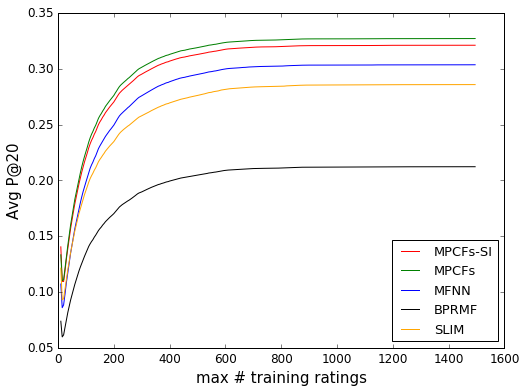

In [23]:
step=5
loc='lower right'
cum=True
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'precision_at_20', step=step,cumulative=cum,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Avg P@20', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'precision_at_20', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_p20.pdf')

avg recall_at_20 for MPCFs-SI model:	0.327696871025
avg recall_at_20 for MPCFs model:	0.334432646711
avg recall_at_20 for MFNN model:	0.295418599665
avg recall_at_20 for BPRMF model:	0.201340287199
avg recall_at_20 for SLIM model:	0.287643147665


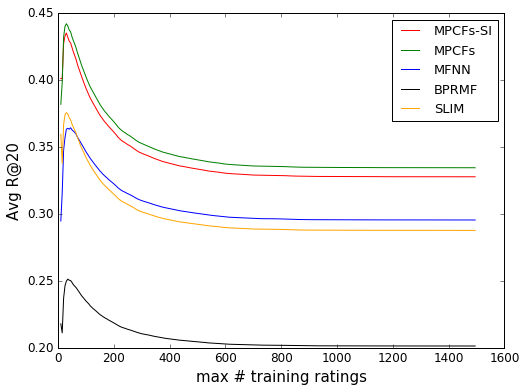

In [24]:
step=5
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'recall_at_20', step=step,cumulative=True,
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Avg R@20', nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MPCFs', fig=fig, color='g', nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='MFNN', fig=fig, color='b', nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='BPRMF', fig=fig, color='black', nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'recall_at_20', step=step,cumulative=True, mlabel='SLIM', fig=fig, color='orange', nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_r20.pdf')

avg reciprocal_rank for MPCFs-SI model:	0.694121702444
avg reciprocal_rank for MPCFs model:	0.703530376288
avg reciprocal_rank for MFNN model:	0.648101133591
avg reciprocal_rank for BPRMF model:	0.442967605723
avg reciprocal_rank for SLIM model:	0.64651759262


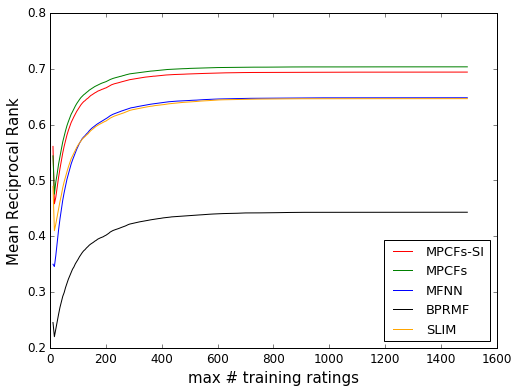

In [25]:
step=5
loc='lower right'
cum=True
nb_cohorts=None
fig = plot_metric(mpcf_si_metrics, 'reciprocal_rank', step=step,cumulative=cum, 
                  mlabel='MPCFs-SI', 
                  xlabel='max # training ratings',
                  ylabel='Mean Reciprocal Rank', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mpcf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MPCFs', fig=fig, color='g', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(mfnn_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='MFNN', fig=fig, color='b', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(bprmf_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='BPRMF', fig=fig, color='black', loc=loc, nb_cohorts=nb_cohorts)
fig = plot_metric(slim_metrics, 'reciprocal_rank', step=step,cumulative=cum, mlabel='SLIM', fig=fig, color='orange', loc=loc, nb_cohorts=nb_cohorts)
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_comparison_mrr.pdf')

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings
Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


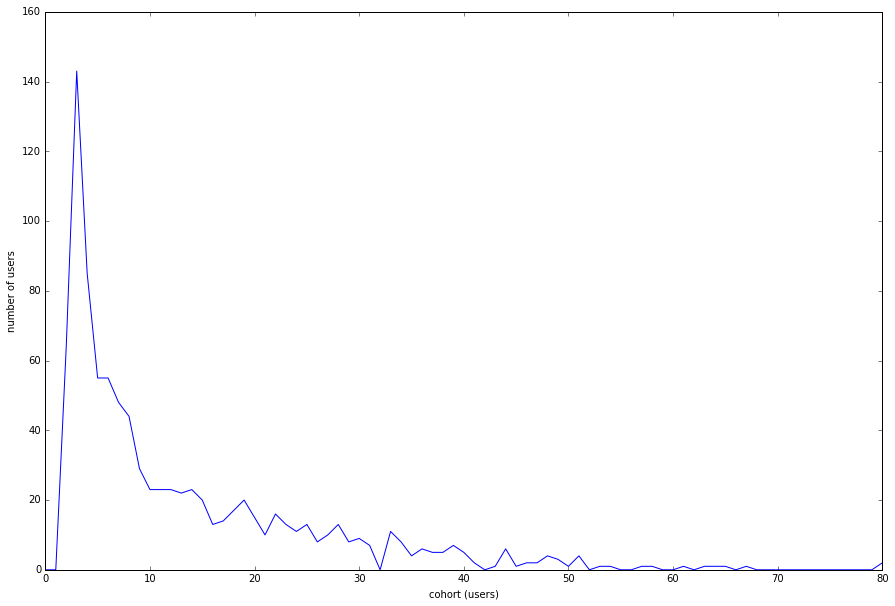

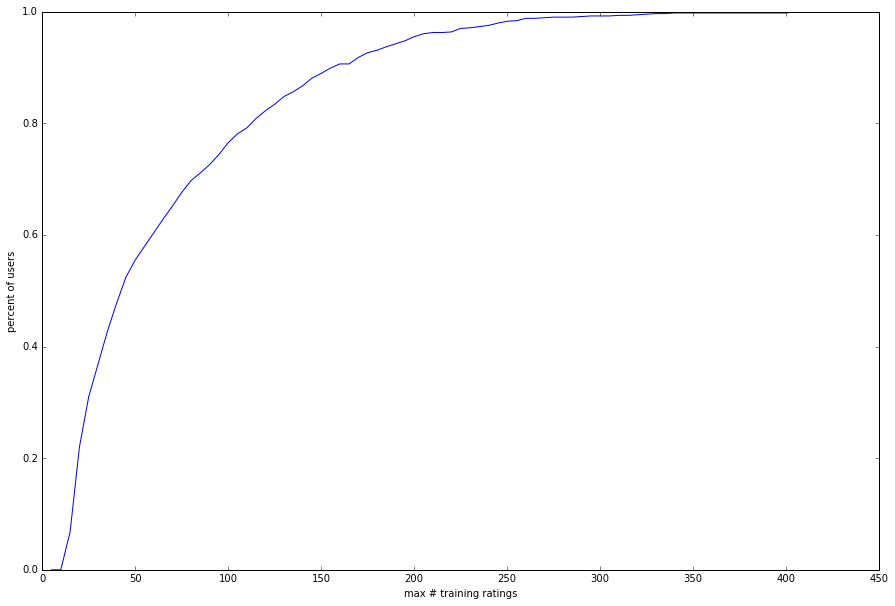

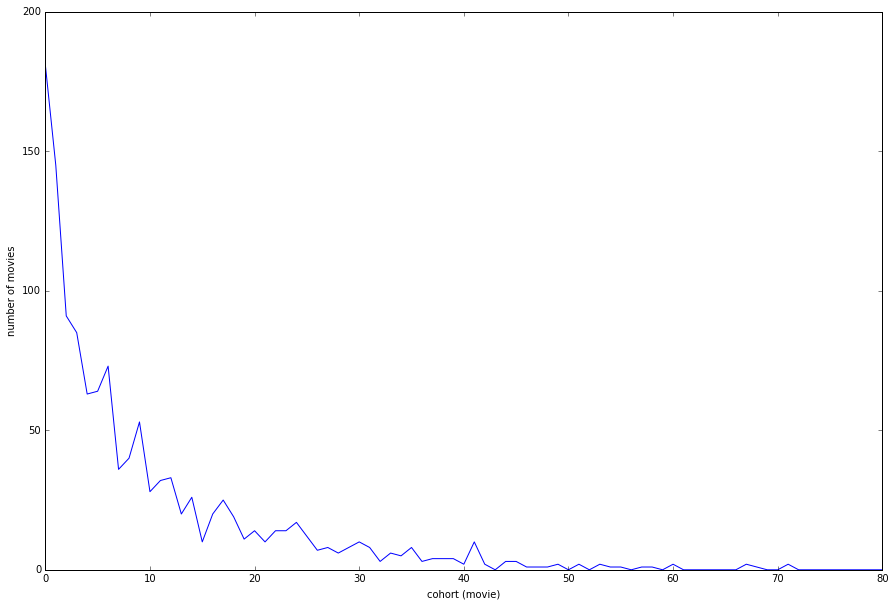

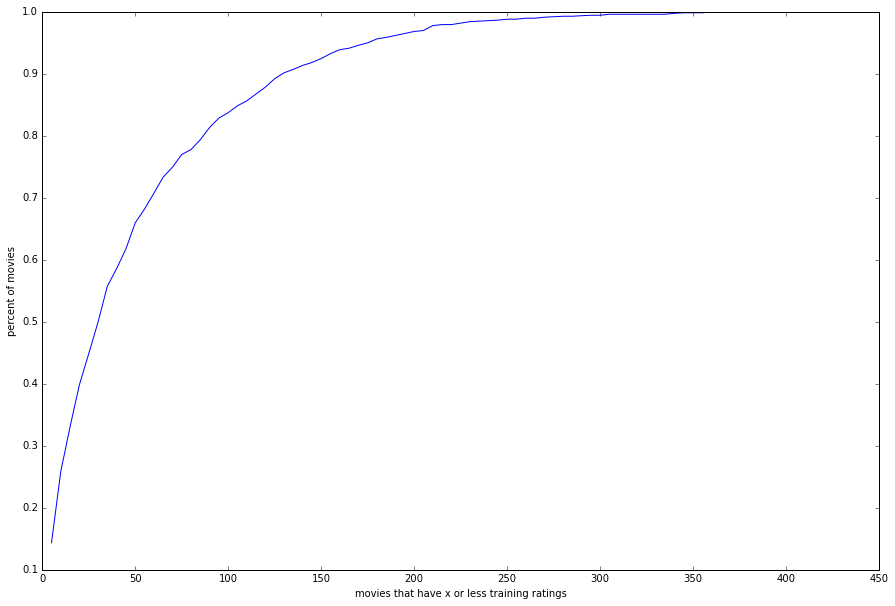

In [26]:
train = pd.read_csv('../data/splits/ml-100k/sparse-item/0.7-train-1.csv')
plot_user_cohort_distribution(train)
plot_movie_cohort_distribution(train)

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings
Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


238

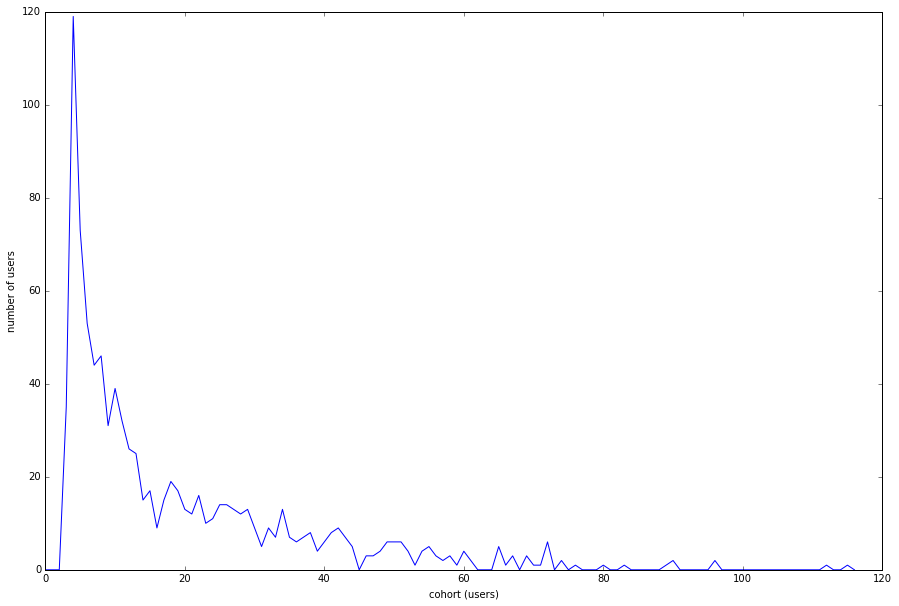

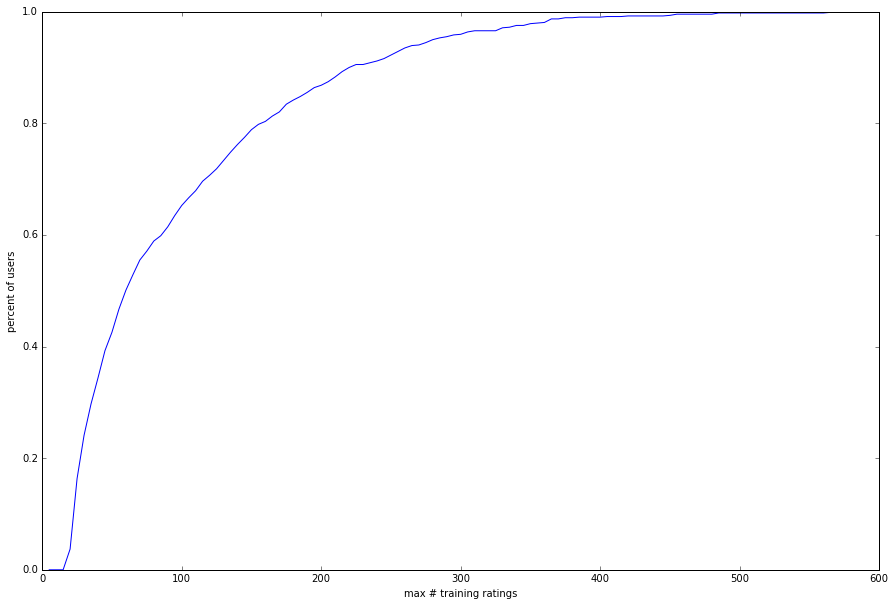

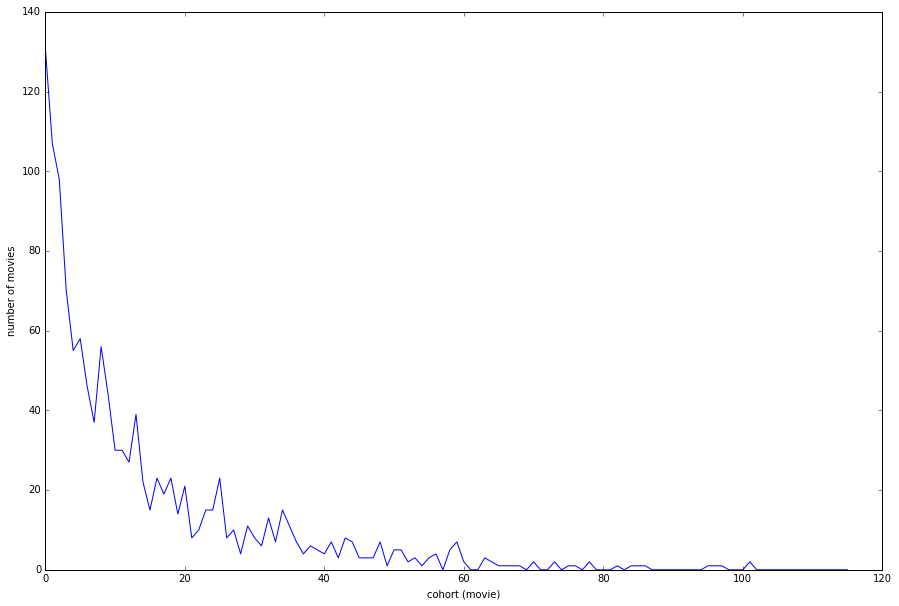

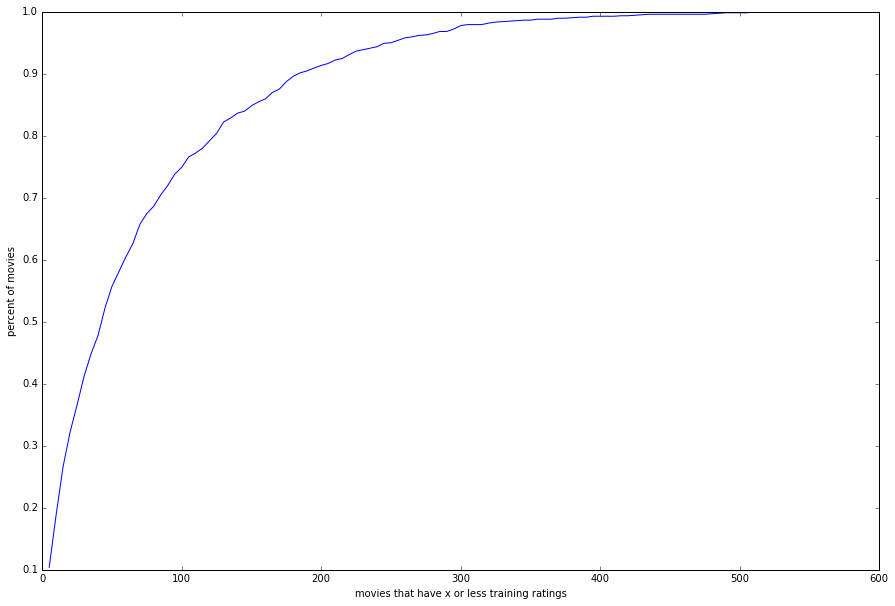

In [27]:
ratings = pd.read_csv('../data/splits/ml-100k/ratings.csv')
plot_user_cohort_distribution(ratings)
plot_movie_cohort_distribution(ratings)
len(ratings.groupby('movie_id').filter(lambda df: len(df) < 10)['movie_id'].unique())

Cohort 0: users who have 0-5 training ratings
Cohort 1: users who have 5-10 training ratings
Cohort 0: movies who have 0-5 training ratings
Cohort 1: movies who have 5-10 training ratings


530

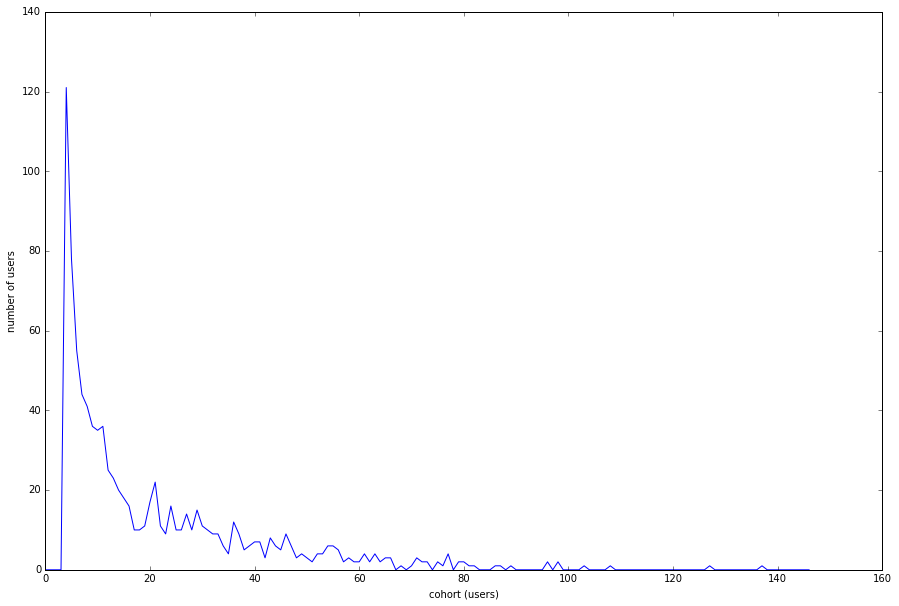

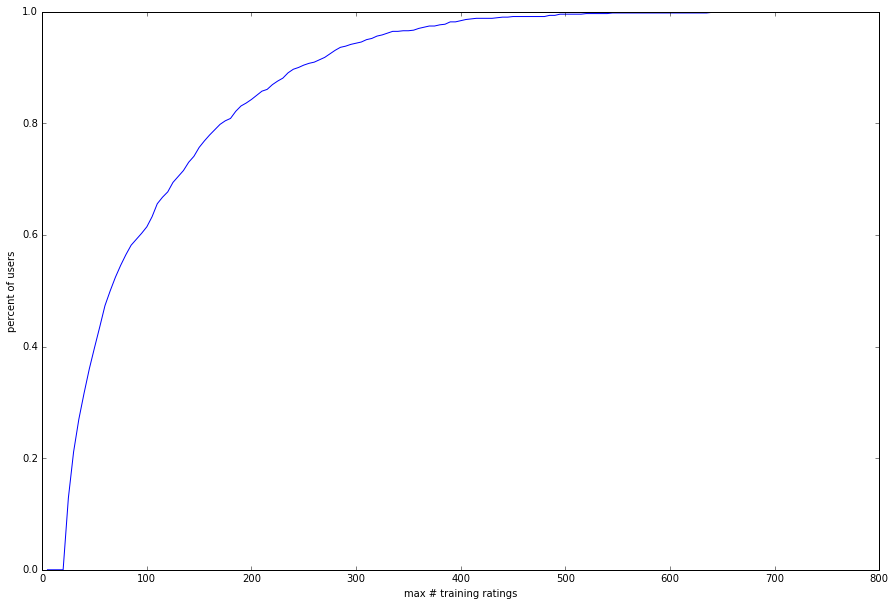

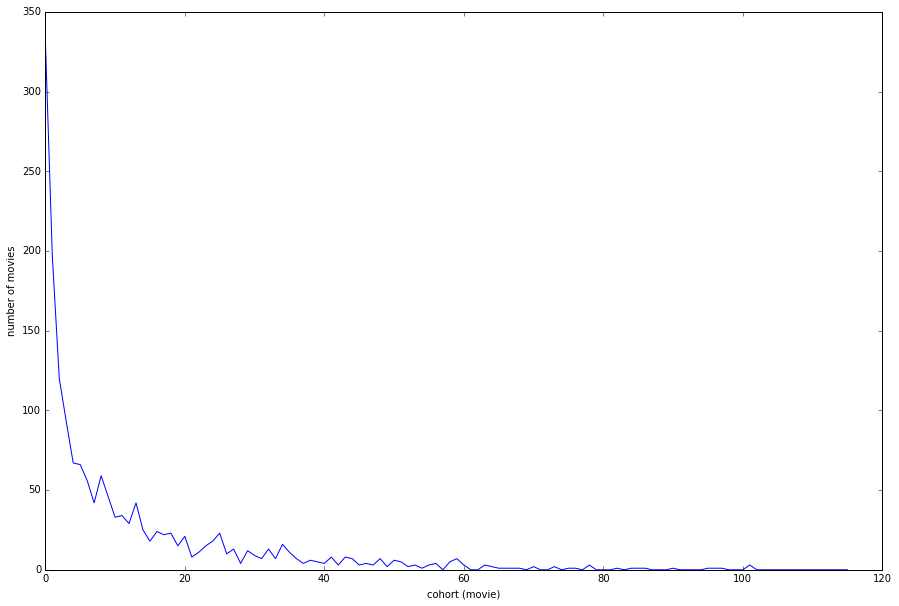

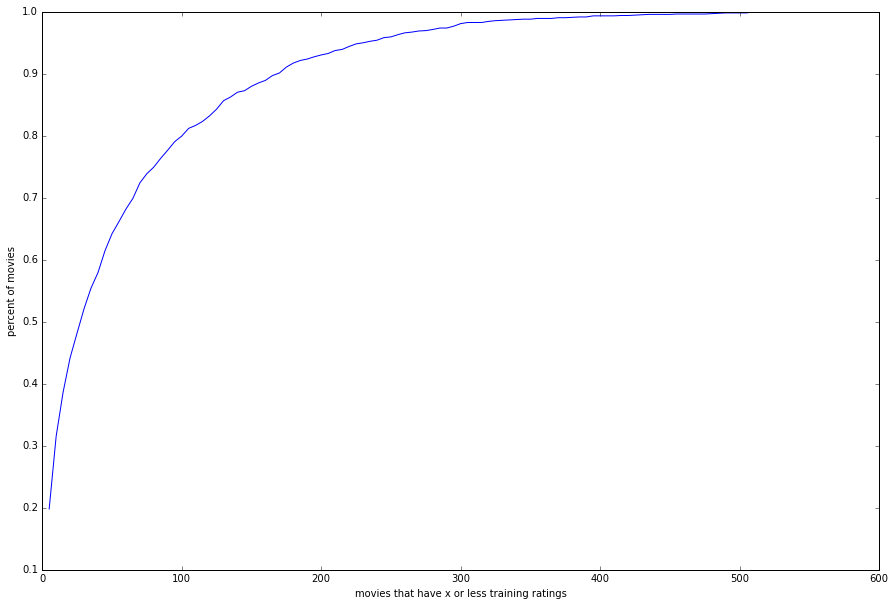

In [28]:
ratings_official = pd.read_csv('../data/splits/ml-100k/ratings-official.csv')
plot_user_cohort_distribution(ratings_official)
plot_movie_cohort_distribution(ratings_official)
len(ratings_official.groupby('movie_id').filter(lambda df: len(df) < 10)['movie_id'].unique())

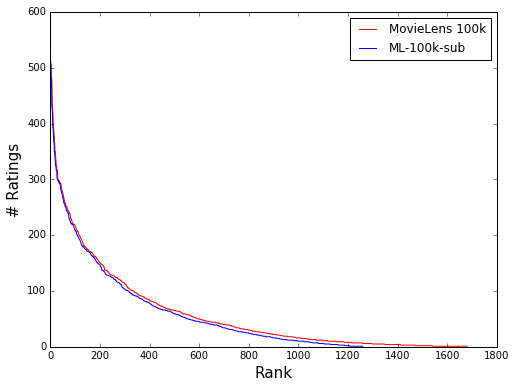

In [29]:
fig = plot_tail(ratings_official, label='MovieLens 100k')
fig = plot_tail(ratings, label='ML-100k-sub', color='b', fig=fig, )
plt.savefig('../../thesis/section-chapter2/figures/ml-100k_tail.pdf')

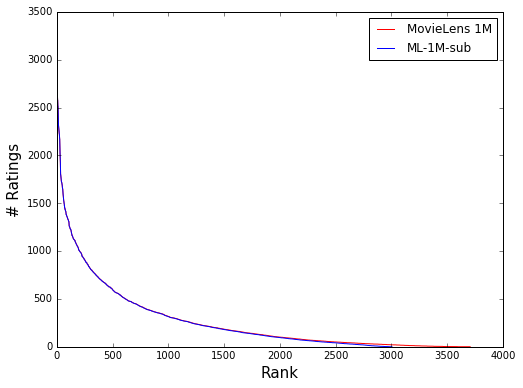

In [30]:
ratings = pd.read_csv('../data/splits/ml-1m/ratings.csv')
ratings_official = pd.read_csv('../data/ml-1m/processed/ratings.csv')

fig = plot_tail(ratings_official, label='MovieLens 1M')
fig = plot_tail(ratings, label='ML-1M-sub', color='b', fig=fig, )
plt.savefig('../../thesis/section-chapter2/figures/ml-1m_tail.pdf')